# Tutorial on customizing unit models in WaterTAP
Demonstration of how to modify existing unit models at flowsheet level

## Dependencies
* Python - Programming language
* Pyomo - Python package for equation-oriented modeling
* IDAES - Python package extending Pyomo for flowsheet modeling
* WaterTAP - Unit models

## Demonstration structure 
* Setting up basic RO flowsheet
* Replace a fixed variable with an equation to study impact of variable performance metrics
* Replace existing constraint with a new one for comparative analysis  
* Replace a fixed cost with variable cost that is a function of operating condition 

## Flowsheet considered in the example
<img src="RO_flowsheet.png" width="500" height="200">

### Import key modules

In [1]:
## Import core components 
# Pyomo core components
from pyomo.environ import (Param,Var, Constraint, TransformationFactory, Reals,    ConcreteModel,
    value,assert_optimal_termination,
    units as pyunits)
from pyomo.network import Arc
# Ideas core components
from idaes.core import FlowsheetBlock
from idaes.core.util.scaling import calculate_scaling_factors, set_scaling_factor
from idaes.core.util.model_statistics import degrees_of_freedom
from watertap.core.solvers import get_solver
from idaes.core.util.scaling import constraint_scaling_transform
from idaes.core.util.initialization import propagate_state
from idaes.models.unit_models import Feed, Product
# WaterTAP core components 
import watertap.property_models.seawater_prop_pack as properties
from watertap.unit_models.reverse_osmosis_1D import (
    ReverseOsmosis1D,
    ConcentrationPolarizationType,
    MassTransferCoefficient,
    PressureChangeType,
)
from watertap.unit_models.pressure_changer import Pump


### Build the flowsheet

In [2]:

m = ConcreteModel()
# create IDAES flowsheet
m.fs = FlowsheetBlock(dynamic=False)
# create seawater property model
m.fs.properties = properties.SeawaterParameterBlock()

# build feed
m.fs.feed = Feed(property_package=m.fs.properties)
m.fs.product = Product(property_package=m.fs.properties)
#build pump
m.fs.pump = Pump(property_package=m.fs.properties)
m.fs.RO = ReverseOsmosis1D(
    property_package=m.fs.properties,
    has_pressure_change=True,
    pressure_change_type=PressureChangeType.calculated,
    mass_transfer_coefficient=MassTransferCoefficient.calculated,
    concentration_polarization_type=ConcentrationPolarizationType.calculated,
    transformation_scheme="BACKWARD",
    transformation_method="dae.finite_difference",
    finite_elements=10,
)
# connect feed to pump
m.fs.feed_to_pump = Arc(source=m.fs.feed.outlet, destination = m.fs.pump.inlet)
#connect pump to RO unit
m.fs.pump_to_ro = Arc(source=m.fs.pump.outlet, destination = m.fs.RO.inlet)
# connect RO permeate to product
m.fs.ro_to_product = Arc(source=m.fs.RO.permeate, destination = m.fs.product.inlet)
TransformationFactory("network.expand_arcs").apply_to(m) 


### Set default values and calculate scaling factors for flowsheet   

In [3]:

m.fs.feed.properties[0].temperature.fix(273 + 25)                      # temperature (K)
m.fs.feed.properties[0].pressure.fix(101325)                           # pressure (Pa)
m.fs.feed.properties[0].flow_mass_phase_comp['Liq', 'H2O'].fix(0.965)  # mass flowrate of H2O (kg/s)
m.fs.feed.properties[0].flow_mass_phase_comp['Liq', 'TDS'].fix(0.035)  # mass flowrate of TDS (kg/s)
m.fs.feed.properties[0].conc_mass_phase_comp[...] # construct concentration props
m.fs.properties.set_default_scaling(
    "flow_mass_phase_comp",
    1/0.965,
    index=("Liq", "H2O"),
)
m.fs.properties.set_default_scaling(
    "flow_mass_phase_comp",
    1/0.035,
    index=("Liq", "TDS"),
)
# to help with initialization, let's build the osmotic pressure variable on the feed block
# which we can use to guess operating pressure for RO unit and set pump pressure during initialization
m.fs.feed.properties[0].pressure_osm_phase[...]
# define pump defaults
m.fs.pump.efficiency_pump[0].fix(0.75)
# scale work and pressures for the pump
set_scaling_factor(m.fs.pump.control_volume.work, 1e-4)
set_scaling_factor(m.fs.pump.control_volume.properties_out[0].pressure, 1e-5)
set_scaling_factor(m.fs.pump.control_volume.properties_in[0].pressure, 1e-5)

# define RO default values for initialization 
# we opt to specify stage area, and inlet velocity
# unfixing width and area
# We also apply variable scaling as we set up each default parameter 

m.fs.RO.feed_side.velocity[0, 0].fix(0.1)

m.fs.RO.area.fix(100)
set_scaling_factor(m.fs.RO.area,1/50)
m.fs.RO.length.unfix()
set_scaling_factor(m.fs.RO.length, 0.1)
m.fs.RO.width.unfix()
set_scaling_factor(m.fs.RO.width, 0.1)

# we need to specify RO permeate pressure
m.fs.RO.permeate.pressure[0].fix(101325)
# we need to specify default values for default mass transport
# and friction factor correlations 
m.fs.RO.feed_side.channel_height.fix(1e-3)
m.fs.RO.feed_side.spacer_porosity.fix(0.9)

# Specify default A and B values, these are defined as m/s/Pa and m/s, respectively. 
m.fs.RO.A_comp[0, "H2O"].fix(3 / (3600 * 1000 * 1e5))
m.fs.RO.B_comp[0, "TDS"].fix(0.15 / (3600 * 1000))

# calculate all the scaling factors 
calculate_scaling_factors(m)


2024-05-14 23:01:28 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.RO.feed_side.area


### Initialize feed, pump, and RO unit

In [4]:
solver = get_solver() # get solver
m.fs.feed.initialize(optarg=solver.options)
propagate_state(m.fs.feed_to_pump)
# get osmotic pressure
osmotic_feed_pressure=value(m.fs.feed.properties[0].pressure_osm_phase['Liq'])
print("Osmotic pressure is {} bar".format(osmotic_feed_pressure/1e5))
m.fs.pump.outlet.pressure[0].fix(osmotic_feed_pressure*1.5) 
m.fs.pump.initialize(optarg=solver.options)
propagate_state(m.fs.pump_to_ro)
m.fs.RO.initialize(optarg=solver.options)

2024-05-14 23:01:28 [INFO] idaes.init.fs.feed.properties: fs.feed.properties State Released.
2024-05-14 23:01:28 [INFO] idaes.init.fs.feed: Initialization Complete.
Osmotic pressure is 25.86985038210651 bar
2024-05-14 23:01:29 [INFO] idaes.init.fs.pump.control_volume.properties_out: fs.pump.control_volume.properties_out State Released.
2024-05-14 23:01:29 [INFO] idaes.init.fs.pump.control_volume: Initialization Complete
2024-05-14 23:01:29 [INFO] idaes.init.fs.pump.control_volume.properties_in: fs.pump.control_volume.properties_in State Released.
2024-05-14 23:01:29 [INFO] idaes.init.fs.pump: Initialization Complete: optimal - Optimal Solution Found
2024-05-14 23:01:29 [INFO] idaes.init.fs.RO.feed_side: Initialization Complete
2024-05-14 23:01:29 [INFO] idaes.init.fs.RO.feed_side.properties: fs.RO.feed_side.properties State Released.
2024-05-14 23:01:29 [INFO] idaes.init.fs.RO.feed_side.properties_interface: fs.RO.feed_side.properties_interface State Released.
2024-05-14 23:01:30 [INFO

### Solve box problem at initialized state and solve to operating state of 50% water recovery

In [5]:

# Check degrees of freedom 
print('We have {} degrees of freedom and expect 0'.format(degrees_of_freedom(m)))
assert degrees_of_freedom(m) == 0
# Solve box problem at initialized state 
result =solver.solve(m, tee=False)
assert_optimal_termination(result)

# apply operating conditions and solve again
m.fs.pump.outlet.pressure[0].unfix()
m.fs.RO.recovery_vol_phase[0.0, "Liq"].fix(0.5)
print('We have {} degrees of freedom and expect 0'.format(degrees_of_freedom(m)))
assert degrees_of_freedom(m) == 0

result =solver.solve(m, tee=True)
assert_optimal_termination(result)
# lets check current solution 
m.fs.RO.report()

We have 0 degrees of freedom and expect 0
We have 0 degrees of freedom and expect 0
ipopt-watertap: Ipopt with user variable scaling and IDAES jacobian constraint scaling
Ipopt 3.13.2: tol=1e-08
constr_viol_tol=1e-08
acceptable_constr_viol_tol=1e-08
bound_relax_factor=0.0
honor_original_bounds=no
nlp_scaling_method=user-scaling


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection 

### Explore relationship between salinity and opertating pressure

In [6]:
# unfix current concentration 
m.fs.feed.properties[0].flow_mass_phase_comp['Liq','TDS'].unfix()
print('Current concentration {}'.format(m.fs.feed.properties[0].conc_mass_phase_comp['Liq','TDS'].value))

# import numpy 
import numpy as np

# define concentrations we are going to sweep over 
concentrations = np.linspace(15,100,10)
pressures = []
for con in concentrations:
    m.fs.feed.properties[0].conc_mass_phase_comp['Liq','TDS'].fix(con)
    assert degrees_of_freedom(m) == 0
    result = solver.solve(m, tee=False)
    assert_optimal_termination(result)
    pressures.append(m.fs.RO.inlet.pressure[0].value/1e5)


Current concentration 35.82617901849218


## Plot feed salinity vs. operating pressure required to achieve 50% water recovery with 50 $m^2$ of membrane area

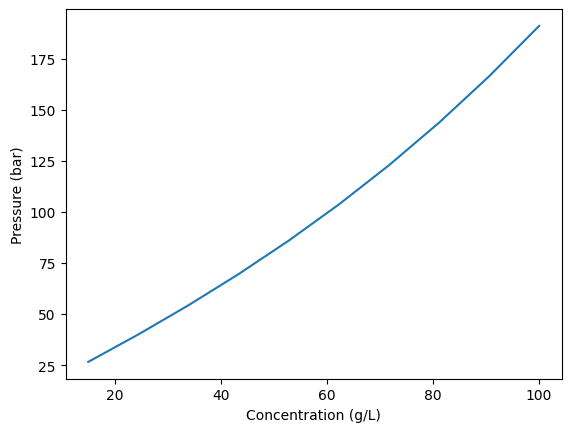

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(concentrations,pressures)
ax.set(xlabel='Concentration (g/L)',ylabel='Pressure (bar)')
plt.show()

### Add relationship between A parameter and inlet pressure to account for compaction effects    

Here we will relate the A value of our RO unit to RO inlet pressure ($P_{inlet}$) as follows:
$$
 A=3 \frac{LMH}{bar}\, for \, P_{inlet}<65\,bar
$$
$$
 A = 3\frac{LMH}{bar}*65/P_{inlet} \, for \, P_{inlet}>=65\,bar
$$

In [8]:
# Imports smooth min and smooth max functions
import idaes.core.util.math as idaesMath

# define our default A value 
m.fs.A_var_initial=Var(initialize=3.0)
m.fs.A_var_initial.fix()
set_scaling_factor(m.fs.A_var_initial, 1/m.fs.A_var_initial.value)

# define constraint that relates A value to P
m.fs.RO.A_pressure_constraint=(
    Constraint(expr=m.fs.RO.A_comp[0, "H2O"]*(3600 * 1000 * 1e5)==
    idaesMath.smooth_min(m.fs.A_var_initial,(m.fs.A_var_initial*(65*1e5/m.fs.RO.inlet.pressure[0])))))
    
m.fs.RO.A_comp[0,'H2O'].unfix()

### Verify that constraint produces expected outcomes 

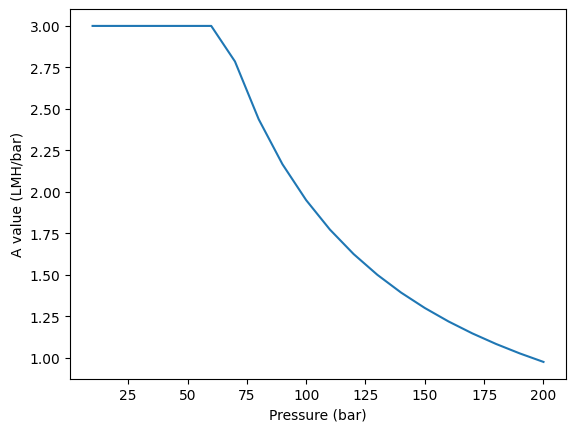

In [9]:
# import method to calculate variable from constraint, allows evaluation of our constraint 
from pyomo.util.calc_var_value import calculate_variable_from_constraint

A_vals=[]
# define range over which to test the constraint
pressures_for_testing = np.linspace(10,200,20)
for pressure in pressures_for_testing:
    m.fs.RO.inlet.pressure[0]=pressure*1e5 # needs to be in Pa
    # this will estimate the RO.A_comp from our constraint.
    calculate_variable_from_constraint(m.fs.RO.A_comp[0, "H2O"],m.fs.RO.A_pressure_constraint)
    A_vals.append(m.fs.RO.A_comp[0, "H2O"].value*(3600 * 1000 * 1e5))

# plot the result 
fig, ax = plt.subplots()
ax.plot(pressures_for_testing,A_vals)
ax.set(xlabel='Pressure (bar)',ylabel='A value (LMH/bar)')
plt.show()

### Initalize A value at operating pressure and solve model with new constraint

In [10]:
# Lets initialize the A value to our actual operating pressure 
m.fs.RO.inlet.pressure[0]=m.fs.pump.outlet.pressure[0].value 
# Calculate the unknown value of A at specified pressure form our constraint 
calculate_variable_from_constraint(m.fs.RO.A_comp[0, "H2O"],m.fs.RO.A_pressure_constraint)


print('We have {} degrees of freedom and expect 0'.format(degrees_of_freedom(m)))
assert degrees_of_freedom(m) == 0

# Solve model with new constraint
result =solver.solve(m, tee=False)
assert_optimal_termination(result)

# Explore how performance changes across feed concentrations 
concentrations = np.linspace(15,100,10)
pressures_with_a_loss = []
actual_a=[]
for con in concentrations:
    m.fs.feed.properties[0].conc_mass_phase_comp['Liq','TDS'].fix(con)
    result =solver.solve(m, tee=False)
    assert_optimal_termination(result)
    pressures_with_a_loss.append(m.fs.RO.inlet.pressure[0].value/1e5)
    actual_a.append(m.fs.RO.A_comp[0, "H2O"].value*(3600 * 1000 * 1e5))
    print("Solved con {}".format(con))


We have 0 degrees of freedom and expect 0
Solved con 15.0
Solved con 24.444444444444443
Solved con 33.888888888888886
Solved con 43.333333333333336
Solved con 52.77777777777778
Solved con 62.22222222222222
Solved con 71.66666666666667
Solved con 81.11111111111111
Solved con 90.55555555555556
Solved con 100.0


### Plot how operating pressure and A value changed during RO operation

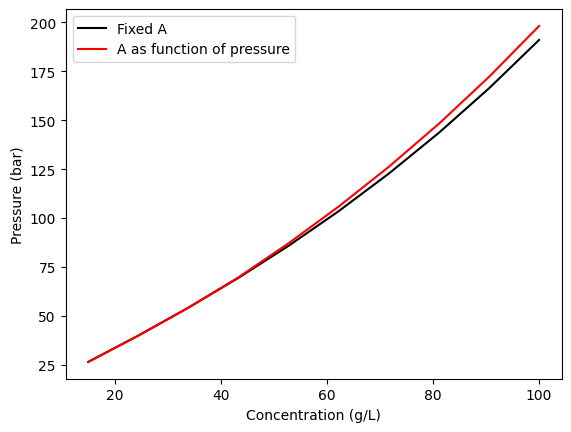

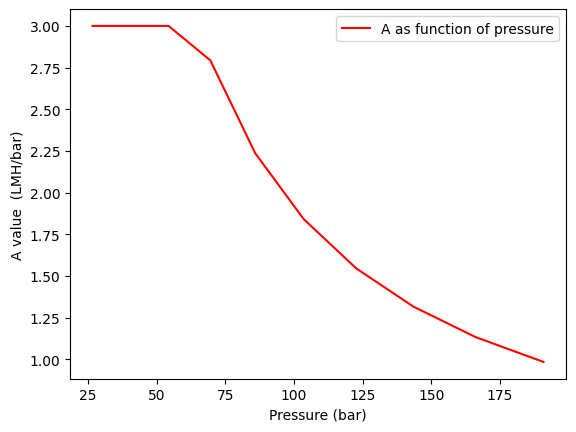

In [11]:

fig, ax = plt.subplots()
ax.plot(concentrations,pressures, color='black', label='Fixed A')
ax.plot(concentrations,pressures_with_a_loss, color='red', label='A as function of pressure')
ax.set(xlabel='Concentration (g/L)',ylabel='Pressure (bar)')
ax.legend()
fig, ax = plt.subplots()
ax.plot(pressures,actual_a,  color='red',label='A as function of pressure')
ax.set(xlabel='Pressure (bar)',ylabel='A value  (LMH/bar)')
ax.legend()
plt.show()

### Replacing an existing constraint with a new one

A common uncertainty in membrane process is prediction of mass transport rates.

Current WaterTap model uses a correlation derived by Guillen et al from CFD simulation of 2D flow in RO channel with a circular spacer filaments. The used correlation is shown below, as well as its implementation in RO model. Current correlation is: 
$$ Sh = 0.45*(Re*Sc)^{0.36}  $$

    @self.Constraint(
        self.flowsheet().config.time,
        self.length_domain,
        self.config.property_package.solute_set,
        doc="Sherwood number",
    )
    def eq_N_Sh_comp(b, t, x, j):
        return (
            b.N_Sh_comp[t, x, j]
            == 0.46 * (b.N_Re[t, x] * b.N_Sc_comp[t, x, j]) ** 0.36
        )

An alternative correlation that could be used has been derived by Schock & Miquel [Desalination, 1987, 64, 339-352] from experiments. This correlation has been shown to be potentially more accurate than the Guillen correlation [Dudchenko et al. ACS ES&T Engineering, https://doi.org/10.1021/acsestengg.1c00496]

$$ Sh = 0.065 * Re^{0.875} * Sc^{0.33} $$

Let's implement the Schock & Miquel correlation instead and observe its overall impact on process operation.

We will further include an Sherwood adjustment factor to enable sensitivity analysis such that our final correlation is: 
$$ Sh = 0.065 * Re^{0.875} * Sc^{0.33} * Sh_{multiplier} $$

In [12]:
# Adding a variable so we can adjust magnitude of Sherwood correlation for sensitivity analysis 
m.fs.Sh_multiplier=Var(initialize=1)
m.fs.Sh_multiplier.fix()

# defining new sherwood correlation 
@m.fs.RO.feed_side.Constraint(
    [0],
    m.fs.RO.length_domain,
    m.fs.properties.solute_set,
    doc="Sherwood number Schock & Miquel",
)
def eq_N_Sh_comp_S_and_M(b, t, x, j):
    return (
        b.N_Sh_comp[t, x, j]
        == (0.065 * b.N_Re[t, x]**0.875 * b.N_Sc_comp[t, x, j] ** 0.33) *m.fs.Sh_multiplier
    )


### Check output of our new correlation against old one

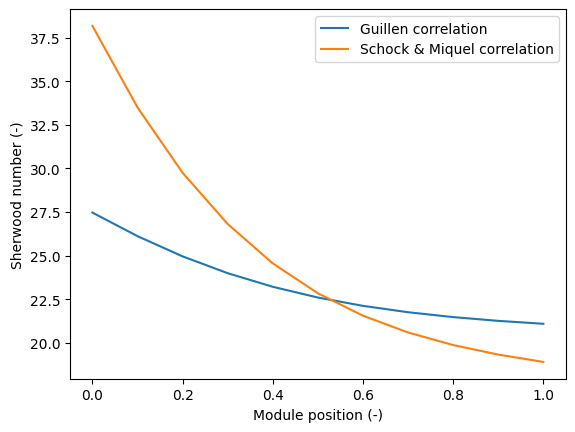

In [13]:
Guillen_sh=[]
Schock_sh=[]
module_position=[]

# grab Sh values estimated using old correlation 
for (t,x,j) in m.fs.RO.feed_side.N_Sh_comp:
    module_position.append(x)    
    Guillen_sh.append(m.fs.RO.feed_side.N_Sh_comp[t,x,j].value)
# grab Sj values using new correlation 
for (t,x,j) in m.fs.RO.feed_side.N_Sh_comp:
    calculate_variable_from_constraint(m.fs.RO.feed_side.N_Sh_comp[t,x,j],m.fs.RO.feed_side.eq_N_Sh_comp_S_and_M[t,x,j])
    Schock_sh.append(m.fs.RO.feed_side.N_Sh_comp[t,x,j].value)

fig, ax = plt.subplots()
ax.plot(module_position,Guillen_sh, label='Guillen correlation')
ax.plot(module_position,Schock_sh, label='Schock & Miquel correlation')
ax.set(xlabel='Module position (-)',ylabel='Sherwood number (-)')
ax.legend()

### Solve the model with Sherwood correlation

In [14]:
# Because the old and new Sherwood numbers have similar values (Within 10x of each other)
# it is not necessary to re-initialize them

# First lets solve with old constraint to get Water Flux and Salt flux, as we did not grab these values earlier on 
'''solve with old constraint'''
# make sure old constraint is active
m.fs.RO.feed_side.eq_N_Sh_comp.activate()
# make sure new constraint is NOT active
m.fs.RO.feed_side.eq_N_Sh_comp_S_and_M.deactivate()
print('We have {} degrees of freedom and expect 0'.format(degrees_of_freedom(m)))
assert degrees_of_freedom(m) == 0
result = solver.solve(m, tee=False)
water_flux_Guillen=[]
salt_flux_Guillen=[]
module_position=[]
# get water and salt flux estimated using Guillen correlation 
for (t,x,p,j) in m.fs.RO.flux_mass_phase_comp:
    if j=='H2O':
        water_flux_Guillen.append(m.fs.RO.flux_mass_phase_comp[t,x,p,j].value*3600)
    if j=='TDS':
        salt_flux_Guillen.append(m.fs.RO.flux_mass_phase_comp[t,x,p,j].value*3600)
        module_position.append(x)

# Now let's activate new Sherwood correlation and solve for new water and salt flux 
'''solve with new constraint'''
# make sure old constraint is NOT active
m.fs.RO.feed_side.eq_N_Sh_comp.deactivate()
# make sure new constraint is active
m.fs.RO.feed_side.eq_N_Sh_comp_S_and_M.activate()
print('We have {} degrees of freedom and expect 0'.format(degrees_of_freedom(m)))
assert degrees_of_freedom(m) == 0
result = solver.solve(m, tee=False)
assert_optimal_termination(result)
water_flux_Schock=[]
salt_flux_Schock=[]
for (t,x,p,j) in m.fs.RO.flux_mass_phase_comp:
    if j=='H2O':
        water_flux_Schock.append(m.fs.RO.flux_mass_phase_comp[t,x,p,j].value*3600)
    if j=='TDS':
        salt_flux_Schock.append(m.fs.RO.flux_mass_phase_comp[t,x,p,j].value*3600)

We have 0 degrees of freedom and expect 0
We have 0 degrees of freedom and expect 0


### Plot comparison of water and salt flux estimated using Guillen and Schock & Miquel correlation

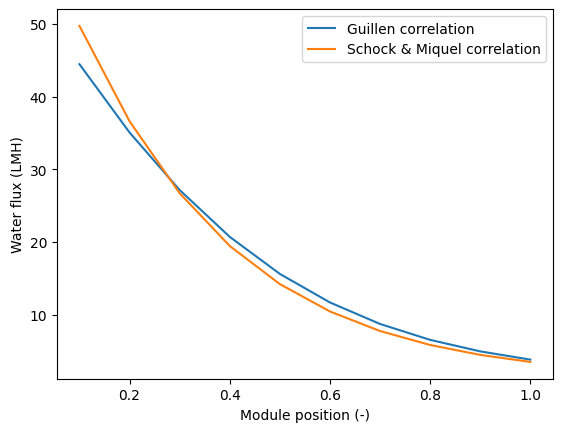

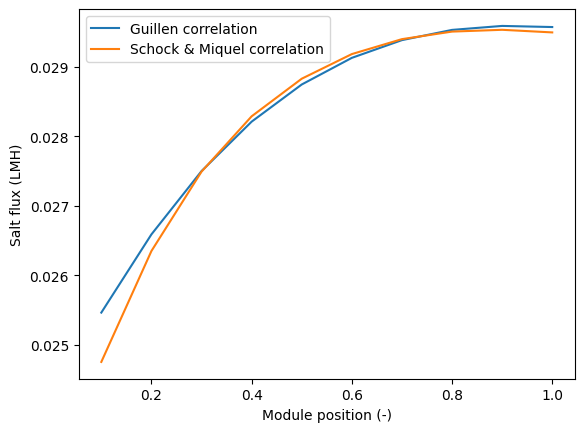

In [15]:


fig, ax = plt.subplots()
ax.plot(module_position,water_flux_Guillen, label='Guillen correlation')
ax.plot(module_position,water_flux_Schock, label='Schock & Miquel correlation')
ax.set(xlabel='Module position (-)',ylabel='Water flux (LMH)')
ax.legend()
fig, ax = plt.subplots()
ax.plot(module_position,salt_flux_Guillen, label='Guillen correlation')
ax.plot(module_position,salt_flux_Schock, label='Schock & Miquel correlation')
ax.set(xlabel='Module position (-)',ylabel='Salt flux (LMH)')
ax.legend()
plt.show()

### Let's explore how changing Sherwood number impact operating pressure

In [16]:
# define adjustments for Sh to sweep over
multipliers = np.linspace(1,2,5)
pressure = []
avg_sh =[] 
for adj in multipliers:
    m.fs.Sh_multiplier.fix(adj)
    assert degrees_of_freedom(m) == 0
    result =solver.solve(m, tee=False)
    pressure.append(m.fs.RO.inlet.pressure[0].value/1e5)
    sh_avg=np.average([m.fs.RO.feed_side.N_Sh_comp[t,x,j].value for (t,x,j) in m.fs.RO.feed_side.N_Sh_comp])
    avg_sh.append(sh_avg)
    print("Solved multiplier {}".format(adj))

Solved multiplier 1.0
Solved multiplier 1.25
Solved multiplier 1.5
Solved multiplier 1.75
Solved multiplier 2.0


### Plot change in operating pressure vs. increase in average Sherwood number 

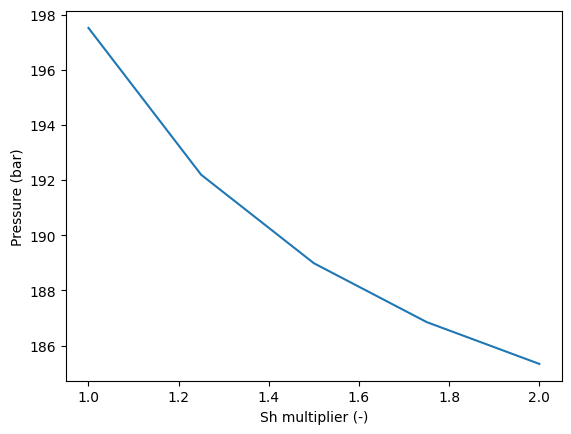

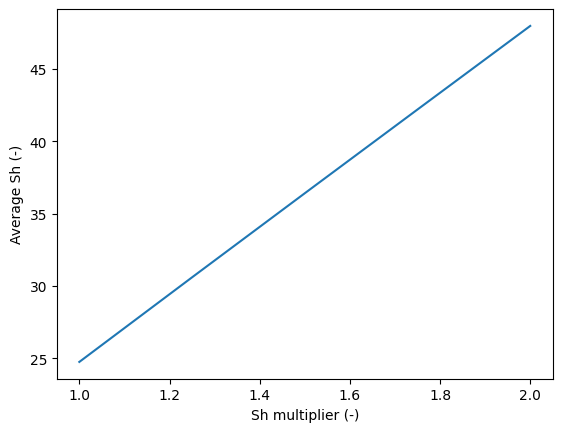

In [17]:
fig, ax = plt.subplots()
ax.plot(multipliers,pressure)
ax.set(xlabel='Sh multiplier (-)',ylabel='Pressure (bar)')
fig, ax = plt.subplots()
ax.plot(multipliers,avg_sh)
ax.set(xlabel='Sh multiplier (-)',ylabel='Average Sh (-)')
plt.show()

## Let's add costing to explore impact of Sh on process cost 

In [18]:
from watertap.costing import WaterTAPCosting
from idaes.core import UnitModelCostingBlock

# add costing block
m.fs.costing = WaterTAPCosting()

# add Pump costing
m.fs.pump.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
# add RO costing
m.fs.RO.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
# Cost the process
m.fs.costing.cost_process()

# track water production rate 
m.fs.costing.add_annual_water_production(m.fs.product.properties[0].flow_vol)

# add LCOW
m.fs.costing.add_LCOW(m.fs.product.properties[0].flow_vol)
# init our costing
m.fs.costing.initialize()

### Let's see how adjusting our Sh value impact process cost

In [19]:
# Let's explore how sh impacts cost 
multipliers = np.linspace(1,2,5)
pressure = []
avg_sh =[] 
lcow = []
for adj in multipliers:
    m.fs.Sh_multiplier.fix(adj)
    assert degrees_of_freedom(m) == 0
    result =solver.solve(m, tee=False)
    pressure.append(m.fs.RO.inlet.pressure[0].value/1e5)
    sh_avg=np.average([m.fs.RO.feed_side.N_Sh_comp[t,x,j].value for (t,x,j) in m.fs.RO.feed_side.N_Sh_comp])
    avg_sh.append(sh_avg)
    lcow.append(value(m.fs.costing.LCOW))
    print("Solved multiplier {}".format(adj))

Solved multiplier 1.0
Solved multiplier 1.25
Solved multiplier 1.5
Solved multiplier 1.75
Solved multiplier 2.0


### Plot LCOW result vs. Sh multiplier 

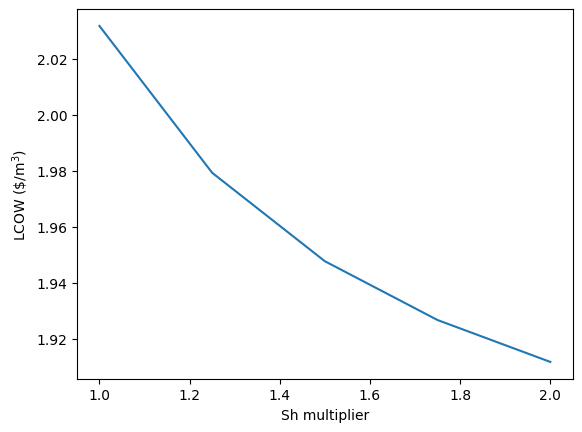

In [20]:
# plot LCOW result 
fig, ax = plt.subplots()
ax.plot(multipliers,lcow)
ax.set(xlabel='Sh multiplier',ylabel='LCOW ($\$$/m$^3$)')
plt.show()

### Lets add a pressure factor to membrane cost

Typical pressure factors relate capital cost of component to operating pressure 

Here we will relate membrane cost to RO inlet pressure ($P_{inlet}$) such that:
$$
    Membrane\,cost = 30 \frac{\$}{m^2}\, for\, P_{inlet} < 60 bar 
$$
$$
    Membrane\,cost = 30\frac{\$}{m^2}* \frac{P_{inlet}}{60}\, bar\, for\, P_{inlet} > 60 bar 
$$


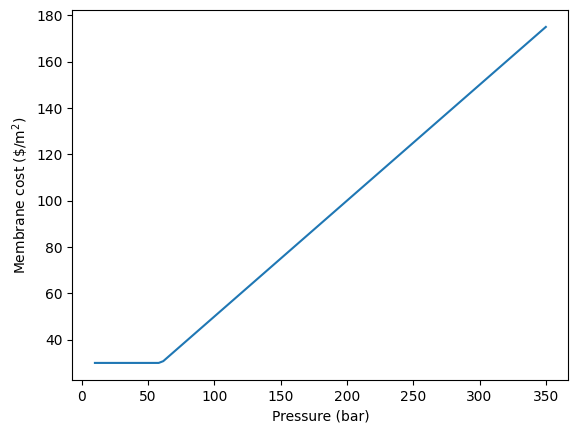

In [21]:
# add a pressure factor to membrane cost 
m.fs.base_membrane_cost=Var(initialize=30)
m.fs.base_membrane_cost.fix()
set_scaling_factor(m.fs.base_membrane_cost, 1/m.fs.base_membrane_cost.value)

# The cost constraint 
m.fs.RO_cost_pressure_constraint=(
    Constraint(expr=m.fs.costing.reverse_osmosis.membrane_cost==
    idaesMath.smooth_max(m.fs.base_membrane_cost,(m.fs.base_membrane_cost*(m.fs.RO.inlet.pressure[0]/(60*1e5))))))

m.fs.costing.reverse_osmosis.membrane_cost.unfix()

# Lets check that our function works and plot the result 
pressures_for_testing=np.linspace(10,350,100)
mem_cost=[]
for pressure in pressures_for_testing:
    m.fs.RO.inlet.pressure[0]=pressure*1e5 # needs to be in kPa
    calculate_variable_from_constraint(m.fs.costing.reverse_osmosis.membrane_cost,m.fs.RO_cost_pressure_constraint)
    mem_cost.append(m.fs.costing.reverse_osmosis.membrane_cost.value)

# plot the cost as function of pressure 
fig, ax = plt.subplots()
ax.plot(pressures_for_testing,mem_cost)
ax.set(xlabel='Pressure (bar)',ylabel='Membrane cost ($\$$/m$^2$)')
plt.show()

### Lets check how the new cost function impacts LCOW vs. fixed membrane cost

In [22]:
# Define concentrations to solve over 
# solving in reverse, as model was previously solved for 100 g/L condition
# this should speed up solving processes
concentrations = np.linspace(100,15,10)

# arrays to store result
pressures = []
lcow_fixed_mem_cost=[]
lcow_variable_mem_cost=[]
mem_cost_fixed=[]
mem_cost_variable=[]
pressures=[]
for con in concentrations:

    m.fs.feed.properties[0].conc_mass_phase_comp['Liq','TDS'].fix(con)

    # first solve for fixed cost
    m.fs.costing.reverse_osmosis.membrane_cost.fix(30)
    m.fs.RO_cost_pressure_constraint.deactivate()
    assert degrees_of_freedom(m) == 0
    result = solver.solve(m, tee=False)
    assert_optimal_termination(result)
    pressures.append(m.fs.RO.inlet.pressure[0].value/1e5)    
    lcow_fixed_mem_cost.append(value(m.fs.costing.LCOW))
    mem_cost_fixed.append(m.fs.costing.reverse_osmosis.membrane_cost.value)
    # second unfix our membrane cost and activate variable cost constraint and solve
    m.fs.costing.reverse_osmosis.membrane_cost.unfix()
    m.fs.RO_cost_pressure_constraint.activate()
    assert degrees_of_freedom(m) == 0
    result = solver.solve(m, tee=False)
    assert_optimal_termination(result)
    lcow_variable_mem_cost.append(value(m.fs.costing.LCOW))
    mem_cost_variable.append(m.fs.costing.reverse_osmosis.membrane_cost.value)

    print("Solved con {}".format(con))

Solved con 100.0
Solved con 90.55555555555556
Solved con 81.11111111111111
Solved con 71.66666666666666
Solved con 62.22222222222222
Solved con 52.77777777777778
Solved con 43.33333333333333
Solved con 33.888888888888886
Solved con 24.444444444444443
Solved con 15.0


### Let's plot LCOW with variable cost result

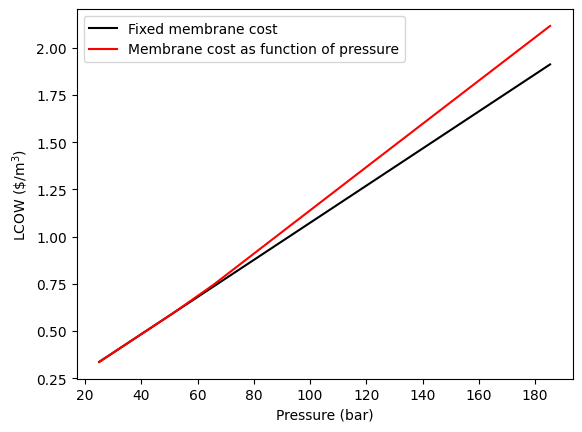

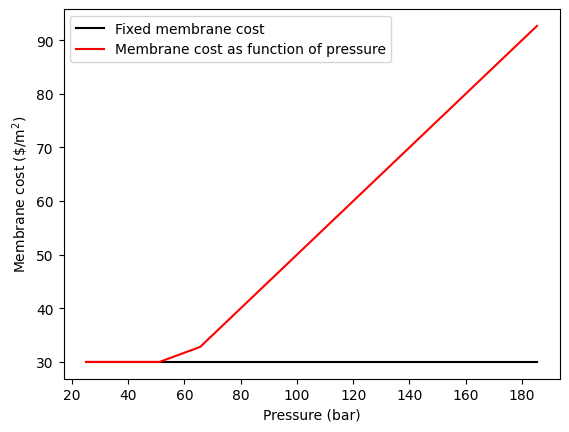

In [23]:
# plot LCOW result 
fig, ax = plt.subplots()
ax.plot(pressures,lcow_fixed_mem_cost,  color='black',label='Fixed membrane cost')
ax.plot(pressures,lcow_variable_mem_cost,  color='red',label='Membrane cost as function of pressure')
ax.set(xlabel='Pressure (bar)',ylabel='LCOW ($\$$/m$^3$)')
plt.legend()

# plot membrane cost
fig, ax = plt.subplots()
ax.plot(pressures,mem_cost_fixed, color='black', label='Fixed membrane cost')
ax.plot(pressures,mem_cost_variable,  color='red',label='Membrane cost as function of pressure')
ax.set(xlabel='Pressure (bar)',ylabel='Membrane cost ($\$$/m$^2$)')
plt.legend()
plt.show()